# Group Stocks Statistically
-----
## Introduction

Group stocks based on the correlation of their returns and see how that compares to standard industry groupings

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

## Get Data

Stock price data was gotten from the Alpha Vantage API. Using a script I wrote called *get_sp_returns.py* to collect the price of the stocks listed on the file, s&p.csv.

In [3]:
df = pd.read_csv('sp500_returns.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

Brought in all data for 2019, for 486 stocks on the S&P 500. Below is how you would have to run the .py file to get the my data. It is worth noting that Alpha Vantage has limits put on their API if you are using the free key.

```
$ python get_sp_returns.py --year 2019 --mode Sequential --key {AlphaVantake Key}
```

A few stocks did not seem to have any price data in 2019 so they will be removed from the dataframe

In [32]:
bye = list(df.drop(columns=['Date']).columns[df.sum() == 0])
bye

['WYN_Consumer Discretionary',
 'XL_Financials',
 'ESRX_Health Care',
 'AET_Health Care',
 'ANDV_Energy',
 'SCG_Utilities',
 'LUK_Financials']

In [33]:
df.drop(columns=bye, inplace=True)

In [34]:
print(f'Year:{df.Date.min().year}, Number of Stocks:{df.shape[1] -1}')

Year:2019, Number of Stocks:486


Calculate the Correlation Matrix

In [35]:
corrMatrix = df.drop(columns=['Date']).corr()
corrMatrix['Industry'] = corrMatrix.index
corrMatrix['Industry'] = corrMatrix['Industry'].str.extract('_(.*)')

In [36]:
corrMatrix.head(3)

,USB_Financials,UDR_Real Estate,ULTA_Consumer Discretionary,UAA_Consumer Discretionary,UA_Consumer Discretionary,UNP_Industrials,UAL_Industrials,UNH_Health Care,UPS_Industrials,URI_Industrials,...,CAG_Consumer Staples,CXO_Energy,COP_Energy,ED_Utilities,STZ_Consumer Staples,GLW_Information Technology,COST_Consumer Staples,COTY_Consumer Staples,CCI_Real Estate,Industry
USB_Financials,1.000000,0.076697,0.164945,0.384569,0.376415,0.515608,0.531796,0.262192,0.438440,0.603088,...,0.169604,0.408282,0.397997,0.031450,0.182562,0.478949,0.357310,0.178256,-0.074473,Financials
UDR_Real Estate,0.076697,1.000000,0.038202,0.115144,0.122935,0.116698,0.096399,0.081650,0.039346,-0.009250,...,0.211952,-0.060586,-0.093920,0.514688,0.175331,0.052042,0.230046,0.033739,0.559230,Real Estate
ULTA_Consumer Discretionary,0.164945,0.038202,1.000000,0.178852,0.192519,0.147417,0.236477,0.080157,0.145593,0.187045,...,0.149122,0.100201,0.125503,-0.018471,0.119469,0.119081,0.266347,0.103475,0.044053,Consumer Discretionary


Check to see if there is any columns with NaNs

In [41]:
corrMatrix.columns[corrMatrix.isna().any()]

Index([], dtype='object')

In [45]:
corrMatrix.groupby(by='Industry')['USB_Financials'].count()

Industry
Consumer Discretionary        80
Consumer Staples              32
Energy                        29
Financials                    67
Health Care                   58
Industrials                   66
Information Technology        69
Materials                     23
Real Estate                   32
Telecommunication Services     3
Utilities                     27
Name: USB_Financials, dtype: int64

## Comparing Statistical Clusters to Industry Groups

### Cluster Map

I am going to try and group stocks using the Cluster Map visualisation from seaborn to try and group together stocks with a good degree of correlation between their returns. However due to the limitations of doing this visibly I am going to filter down the data to 3 industrys.

In [56]:
plot_df = corrMatrix[corrMatrix.Industry.isin(['Energy', 'Real Estate'])].drop(columns=['Industry'])
p = sns.clustermap(plot_df, annot=False, col_cluster=False, cmap='coolwarm', figsize=(60,30), method='ward')
sns.boxplot(data=plot_df, ax=p.ax_col_dendrogram.axes, palette='Set2')
p.savefig("clustermap.png")
plt.close(p.fig)

The clustermap managed to group the stocks into 2 large groups and primarily managed to group Energy stocks in the same group and the same for Real Estate. However this was not perfect as there were 4 real estate stocks which fell into the Energy group. these were: WY, HST, SPG, MAC. So from the small sample it does seem that stocks within the same industry daily return vary together.

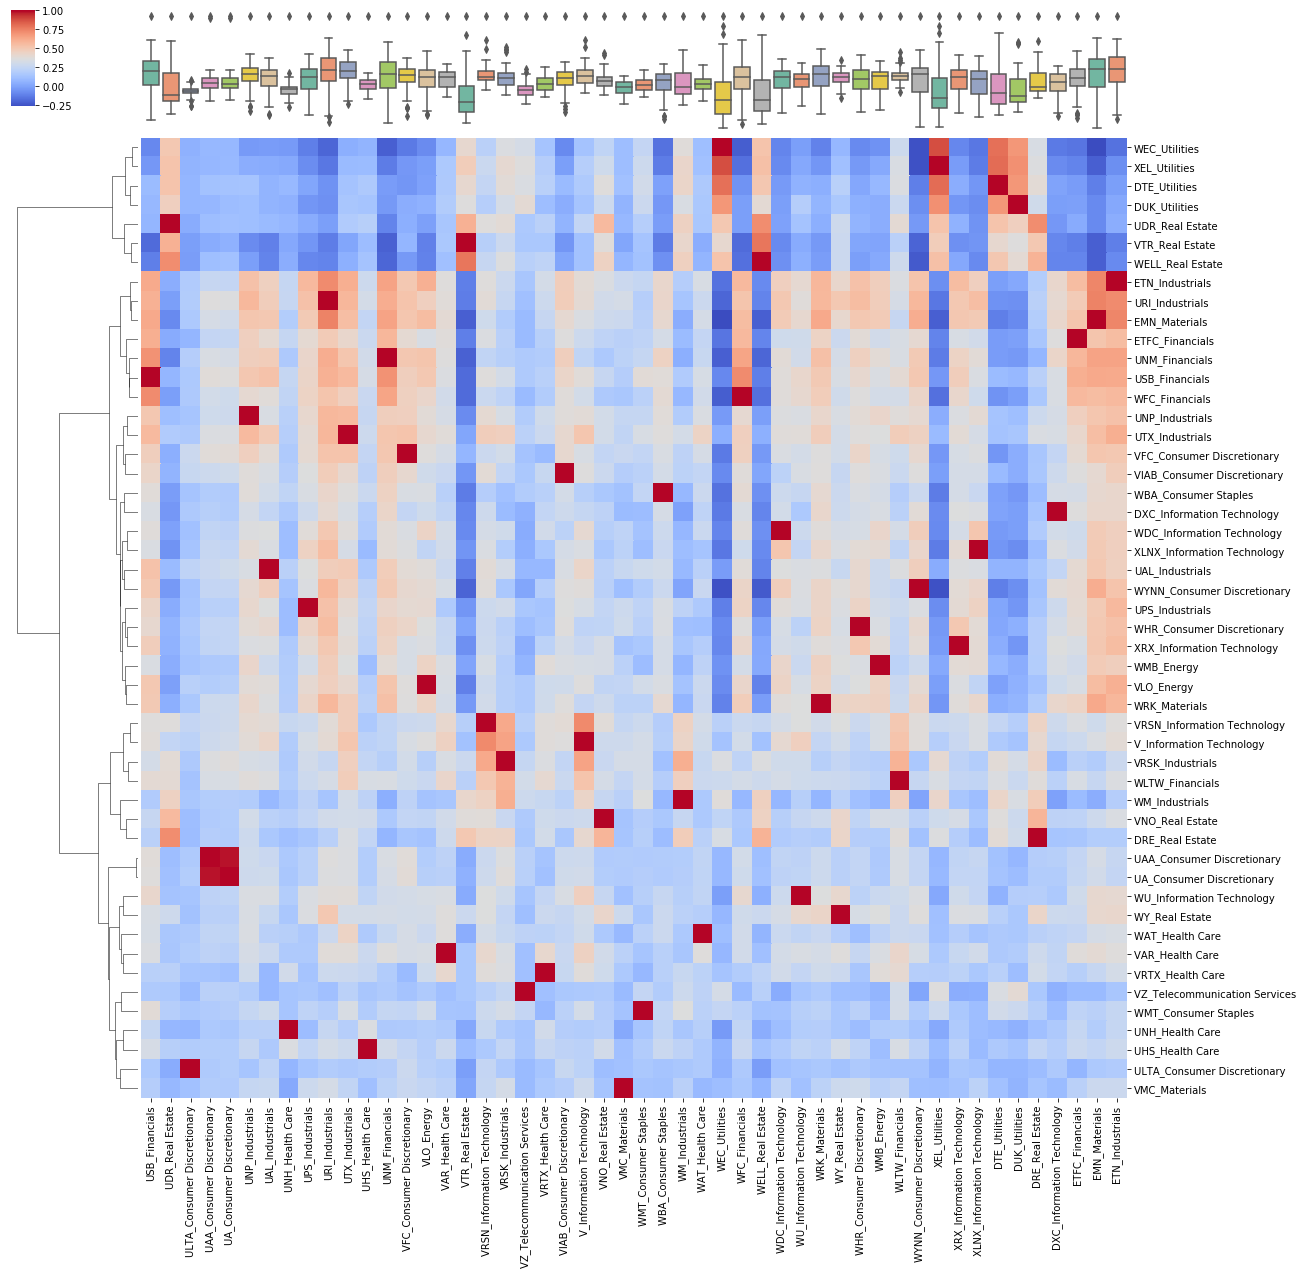

In [71]:
# Below is just an illustration of what clustermap.png looks like
plot_df = corrMatrix[corrMatrix.columns[:50]].iloc[:50]
p = sns.clustermap(plot_df, annot=False, col_cluster=False, cmap='coolwarm', figsize=(20,20), method='ward')
sns.boxplot(data=plot_df, ax=p.ax_col_dendrogram.axes, palette='Set2')

### Principal Compnent Analysis

Another method we could try and use when grouping stocks together is principal component analysis to reduce the number of feautures to 2 and plot this on a scatter plot to see if we can see groups/clusters visually.

In [63]:
corrMatrix_scaled = StandardScaler().fit_transform(corrMatrix.drop(columns=['Industry']))

My Palette for the industries

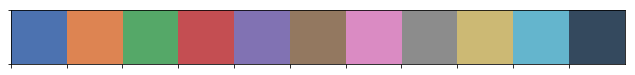

In [140]:
c_pal = sns.color_palette(sns.color_palette('deep') + ["#34495e"])
sns.palplot(c_pal)

#### 2D

In [64]:
pca = PCA(n_components=2)
corrMatrix_pca = pca.fit_transform(corrMatrix_scaled)
plot_pca = pd.DataFrame(data=corrMatrix_pca, columns=['PC_1', 'PC_2'])
plot_pca['Industry'] = corrMatrix['Industry'].reset_index(drop=True)

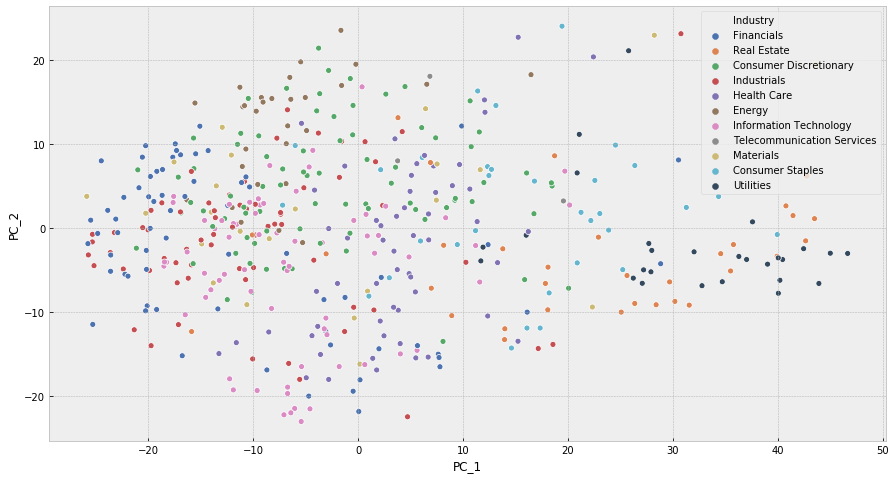

In [149]:
with plt.style.context(['bmh']):
    plt.figure(figsize=(15,8))
    sns.scatterplot(data=plot_pca, x='PC_1', y='PC_2', hue='Industry', palette=c_pal)

In [74]:
print(f'Principal Component 1 explains {int(pca.explained_variance_ratio_[0]*100)}% '
      f'and Principal Component 2 explains {int(pca.explained_variance_ratio_[1]*100)}% of the variation'
     )

Principal Component 1 explains 54% and Principal Component 2 explains 18% of the variation


#### 3D

In [75]:
pca = PCA(n_components=3)
corrMatrix_pca = pca.fit_transform(corrMatrix_scaled)
plot_pca = pd.DataFrame(data=corrMatrix_pca, columns=['PC_1', 'PC_2', 'PC_3'])
plot_pca['Industry'] = corrMatrix['Industry'].reset_index(drop=True)

In [82]:
print(f'Principal Component 1 explains {int(pca.explained_variance_ratio_[0]*100)}% '
      f'Principal Component 2 explains {int(pca.explained_variance_ratio_[1]*100)}% '
      f'and Principal Component 3 explains {int(pca.explained_variance_ratio_[2]*100)}% of the variation'
     )

Principal Component 1 explains 54% Principal Component 2 explains 18% and Principal Component 3 explains 3% of the variation


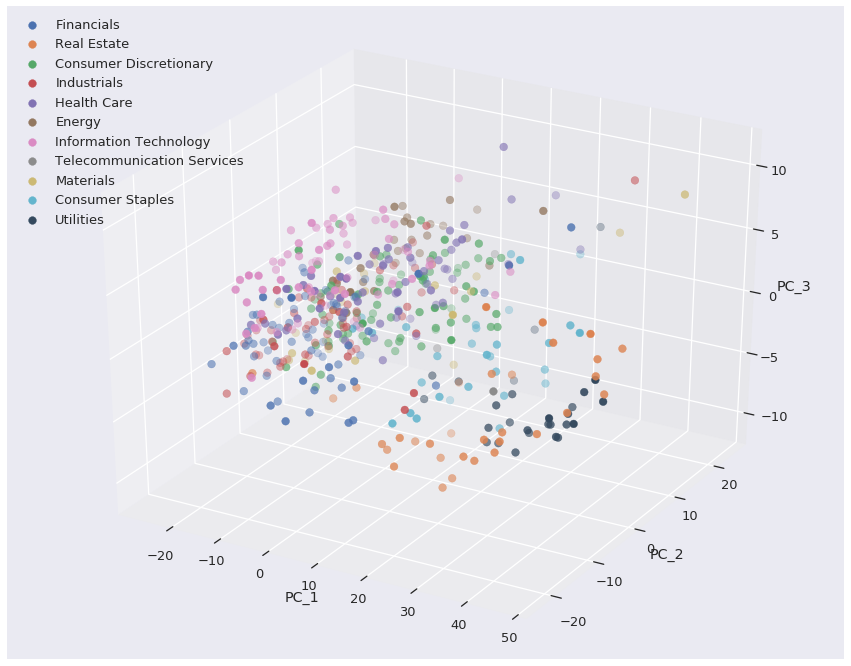

In [154]:
with plt.style.context(['seaborn-talk', 'seaborn-darkgrid']):
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111, projection='3d')
    
    for ind, c in zip(plot_pca['Industry'].unique(), c_pal.as_hex()):
        ax.scatter(
            plot_pca[plot_pca.Industry==ind].PC_1,
            plot_pca[plot_pca.Industry==ind].PC_2,
            plot_pca[plot_pca.Industry==ind].PC_3,
            label=ind,
            color=c,
            s=60
        )

    ax.set_xlabel('PC_1')
    ax.set_ylabel('PC_2')
    ax.set_zlabel('PC_3')
    ax.legend()

Both the 2D and 3D shows that there is some clustering for stocks in the same industry. Howvever they are not clustered very tightly and there is a lot of overlapping

### K Means Clustering

In [156]:
kmean = KMeans(n_clusters=corrMatrix.Industry.nunique())

In [158]:
kmean.fit(corrMatrix_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [161]:
k_df = pd.DataFrame({'stock': corrMatrix.index, 'kmeans': kmean.labels_})
k_df['Industry'] = k_df.stock.str.extract('_(.*)')

In [173]:
result = k_df.groupby(by=['kmeans','Industry'])['stock'].count().to_frame('count').sort_values(by=['kmeans','count'], ascending=False).reset_index()

The below chart show that the kmeans group dont match 1 to 1 with a predefined industry. 

<Figure size 432x288 with 0 Axes>

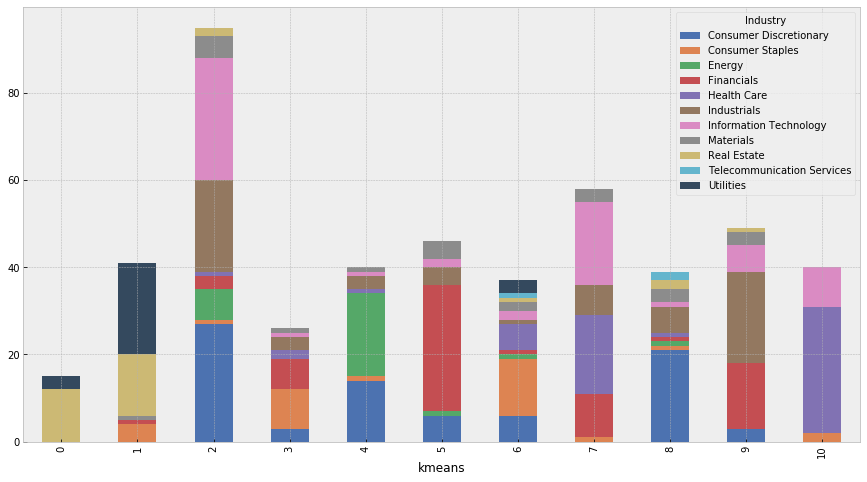

In [188]:
with plt.style.context(['bmh']):
    plt.figure()
    plot_df = result.pivot(index='kmeans', columns='Industry', values='count')
    plot_df.plot( kind='bar', stacked=True, figsize=(15,8), colormap=ListedColormap(c_pal.as_hex()))

However when overlaying this with on the 2 dimensional PCA chart from earlier. It looks like it has done a good good job of providing clear clusters. So maybe worth experimenting further using kmeans to see what statistical groups I get as 11 clusters may not be the correct amount of groups.

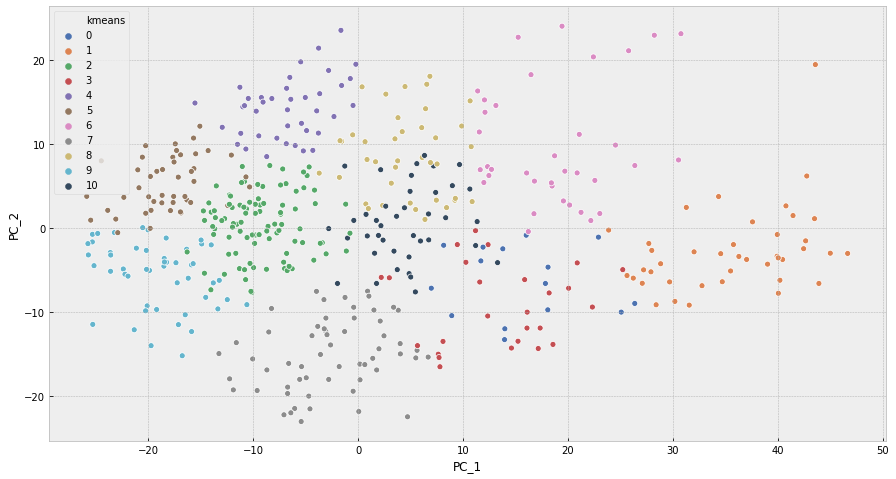

In [190]:
pca = PCA(n_components=2)
corrMatrix_pca = pca.fit_transform(corrMatrix_scaled)
plot_pca = pd.DataFrame(data=corrMatrix_pca, columns=['PC_1', 'PC_2'])
plot_pca['kmeans'] = kmean.labels_
with plt.style.context(['bmh']):
    plt.figure(figsize=(15,8))
    sns.scatterplot(data=plot_pca, x='PC_1', y='PC_2', hue='kmeans', palette=c_pal)

## Grouping Stocks with KMeans

### Decide the Number of Clusters

In [225]:
KM = [KMeans(n_clusters=i).fit(corrMatrix_scaled) for i in range(1,31)]
centroids = [k.cluster_centers_ for k in KM]

In [226]:
D_k = [cdist(corrMatrix_scaled, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/corrMatrix_scaled.shape[0] for d in dist]

In the chart below we plot the average variance within the cluster, for kmeans with different number of clusters. The elbow of the curve is the ideal number clusters we should run KMeans for. In this case it is **n_cluster = 9**

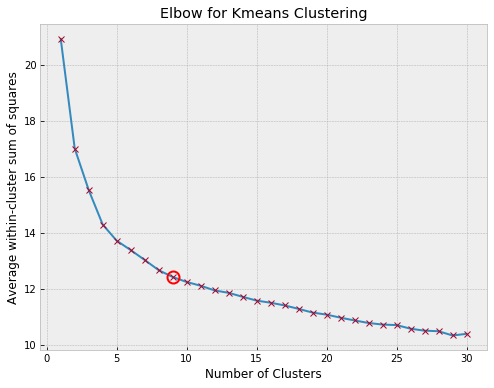

In [244]:
with plt.style.context(['bmh']):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(range(1,31), avgWithinSS, '-')
    ax.plot(range(1,31), avgWithinSS, 'x')
    ax.plot(9, avgWithinSS[8], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Average within-cluster sum of squares')
    ax.set_title('Elbow for Kmeans Clustering')

### Visualising KMeans for those cluster

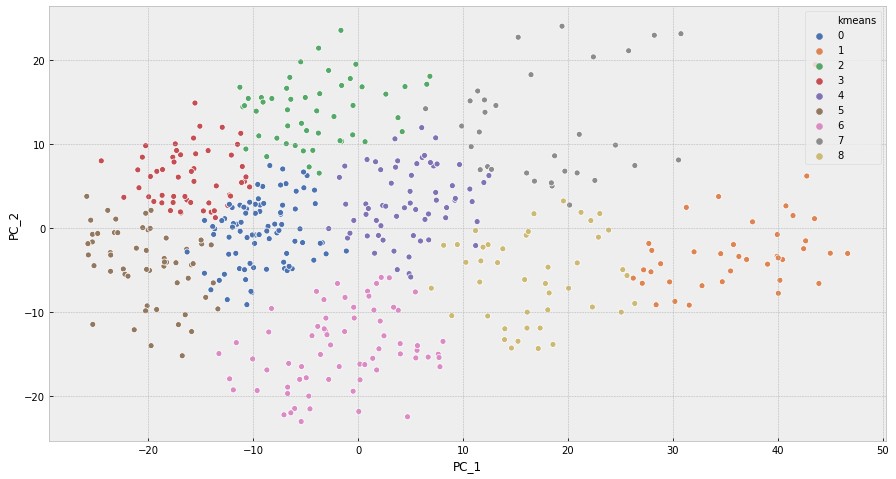

In [236]:
pca = PCA(n_components=2)
corrMatrix_pca = pca.fit_transform(corrMatrix_scaled)
plot_pca = pd.DataFrame(data=corrMatrix_pca, columns=['PC_1', 'PC_2'])
plot_pca['kmeans'] = KM[8].labels_
with plt.style.context(['bmh']):
    plt.figure(figsize=(15,8))
    sns.scatterplot(data=plot_pca, x='PC_1', y='PC_2', hue='kmeans', palette=c_pal[:9])

In [248]:
k_df = pd.DataFrame({'stock_industry': corrMatrix.index, 'kmeans': KM[8].labels_})
k_df['stock'] = k_df.stock_industry.str.extract('(.*)_')
k_df.drop(columns=['stock_industry']).to_csv('stock_clustered.csv', index=False) #saved to be used for later projects

# End
-----